In [3]:
import numpy as np
from numba import cuda
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
# labwork 6a: grayscale image binarization
@cuda.jit
def binarize_kernel(src, dst, threshold):
    tx = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    ty = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    if ty < src.shape[0] and tx < src.shape[1]:
        # Map function f(x) = 255
        dst[ty, tx] = 255 if src[ty, tx] >= threshold else 0

# labwork 6b: brightness control
@cuda.jit
def brightness_kernel(src, dst, factor):
    tx = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    ty = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    if ty < src.shape[0] and tx < src.shape[1]:
        if len(src.shape) == 3:  # Color image
            for c in range(3):
                value = int(src[ty, tx, c] * factor)
                dst[ty, tx, c] = min(max(value, 0), 255)
        else:  # Grayscale image
            value = int(src[ty, tx] * factor)
            dst[ty, tx] = min(max(value, 0), 255)

# labwork 6c: blending two images
@cuda.jit
def blend_kernel(src1, src2, dst, blend_factor):
    tx = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    ty = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    if ty < src1.shape[0] and tx < src1.shape[1]:
        if len(src1.shape) == 3:  # Color image
            for c in range(3):
                dst[ty, tx, c] = int(
                    src1[ty, tx, c] * blend_factor + 
                    src2[ty, tx, c] * (1 - blend_factor)
                )
        else:  # Grayscale image
            dst[ty, tx] = int(
                src1[ty, tx] * blend_factor + 
                src2[ty, tx] * (1 - blend_factor)
            )

Image size: 5760x3840
Grid size: 360x240
Block size: 16x16
Binarizing with threshold: 128


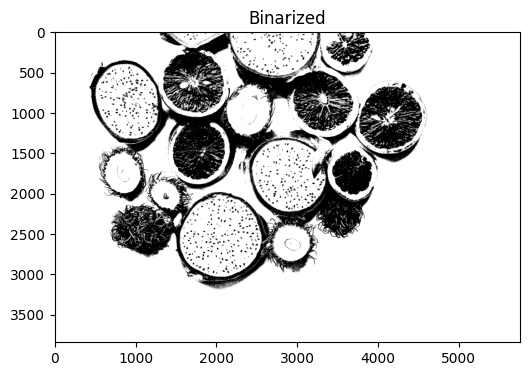

In [8]:
def process_image(operation, image_path1, image_path2=None, block_size=(16, 16), **kwargs):
    # Load image
    image1 = np.array(Image.open(image_path1))
    height, width = image1.shape[:2]
    print(f"Image size: {width}x{height}")

    # Calculate grid dimensions need for image (assign needed threads)
    grid_x = (width + block_size[0] - 1) // block_size[0]
    grid_y = (height + block_size[1] - 1) // block_size[1]
    print(f"Grid size: {grid_x}x{grid_y}")
    print(f"Block size: {block_size[0]}x{block_size[1]}")

    # Convert to grayscale if needed for binarization
    if operation == 'binarize':
        if len(image1.shape) == 3:
            image1 = np.mean(image1, axis=2).astype(np.uint8)

    # Allocate memory on device
    d_image1 = cuda.to_device(image1)
    d_result = cuda.device_array_like(image1)

    # Process based on operation type
    if operation == 'binarize':
        threshold = kwargs.get('threshold', 128)
        print(f"Binarizing with threshold: {threshold}")
        binarize_kernel[(grid_x, grid_y), block_size](d_image1, d_result, threshold)

    elif operation == 'brightness':
        factor = kwargs.get('factor', 1.5)
        print(f"Adjusting brightness with factor: {factor}")
        brightness_kernel[(grid_x, grid_y), block_size](d_image1, d_result, factor)

    elif operation == 'blend':
        if image_path2 is None:
            raise ValueError("Second image path required for blending")
        
        # Load and check second image
        image2 = np.array(Image.open(image_path2))
        if image1.shape != image2.shape:
            raise ValueError("Images must have the same dimensions for blending")
        
        d_image2 = cuda.to_device(image2)
        blend_factor = kwargs.get('blend_factor', 0.5)
        print(f"Blending images with factor: {blend_factor}")
        blend_kernel[(grid_x, grid_y), block_size](d_image1, d_image2, d_result, blend_factor)

    # Get result back from device
    result = d_result.copy_to_host()
    return result

def main():
    # usage
    block_size = (16, 16)
    
    # 6a: Binarization
    binary_result = process_image(
        'binarize', 
        'image1.jpg', 
        block_size=block_size,
        threshold=128
    )
    
    # 6b: Brightness adjustment
    # bright_result = process_image(
    #     'brightness', 
    #     'image1.jpg', 
    #     block_size=block_size,
    #     factor=1.5
    # )
    
    # 6c: Image blending
    # blend_result = process_image(
    #     'blend', 
    #     'image1.jpg',
    #     'iamge1.jpg', 
    #     block_size=block_size,
    #     blend_factor=0.7
    # )
    
    # Display results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(binary_result, cmap='gray')
    plt.title('Binarized')
    
    # plt.subplot(132)
    # plt.imshow(bright_result)
    # plt.title('Brightness Adjusted')
    
    # plt.subplot(133)
    # plt.imshow(blend_result)
    # plt.title('Blended')
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()